### Module 25: GAN (Generative adversarial networks)
0. 非監督學習的重要訓練方法，GAN 神經網路包含兩個部分: Generator 跟 Discriminator<br>
1. Generator 的輸入是 noise ，輸出是一個以假亂真的照片
2. Discriminator 可以辨識出哪些是真照片，哪些是假照片 
3. 一開始 Discriminator 無法很好的辨識照片是真的還是假的
4. Discriminator 會開始演化: 於是它開始可以辨識出 Generator 產生出來的假照片
5. 為了騙Discriminator,Generator會開始演化:Generator產生的假照片又可以騙過 Discriminator 
6. 以此類推， Generator 及 Discriminator 不斷演化下去
<br>(1)我們最終得到一個可以假亂真的照片Generator(2)還有很會辨識真假照片的Discriminator
7. Generator 的輸入是 noise，輸出是一個以假亂真的照片,Discriminator可辨識出哪些是真照片or假照片
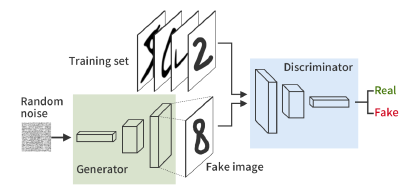
9. GAN 整體演算法如下:
• 初始化Generator及其參數及其參數 𝜃𝑔且初始化 Discriminator 及其參數 𝜃𝑑<br>
• 在每次訓練迭代當中: 
<br> (1) 固定 Generator 並更新 Discriminator 參數多次
<br> (2) 固定 Discriminator 並更新 Generator 一次

In [ ]:
import torch.nn as nn
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
batch_size = 64 # Load data
train_set = datasets.MNIST('./dataset/mnist', train=True, download=True, transform=transform)
test_set = datasets.MNIST('./dataset/mnist', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
start_time = time.time(); plt.rcParams['image.cmap'] = 'gray'
def show_images(images): # 畫圖用
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1);plt.imshow(image.reshape(28, 28))

In [ ]:
epochs = 200 ; lr = 0.0002  # Settings
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256),  # fc  # input 784 D
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),  # fc
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),    # fc  # output 0~1 數值for 真假評分
            nn.Sigmoid()         )
    def forward(self, input):
        return self.main(input)
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),    # 128 D noise
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),    #output :784 D (28*28 image) 
            nn.Tanh()         )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Discriminator Loss => BCELoss
def d_loss_function(inputs, targets):
    return nn.BCELoss()(inputs, targets)
def g_loss_function(inputs):   # generator loss
    targets = torch.ones([inputs.shape[0], 1])
    targets = targets.to(device)
    return nn.BCELoss()(inputs, targets)
# Model
G = generator().to(device)
D = discriminator().to(device)
print(G) ; print(D)
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Train
for epoch in range(epochs):
    epoch += 1
    for times, data in enumerate(train_loader):
        times += 1
        # 先 D 
        real_inputs = data[0].to(device)
        test = 255 * (0.5 * real_inputs[0] + 0.5)   # image 還原
        real_inputs = real_inputs.view(-1, 784)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device) # 真image label =1
        # 再 G
        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)  # 假image label =0
        outputs = torch.cat((real_outputs, fake_outputs), 0) # 2 output 連一起
        targets = torch.cat((real_label, fake_label), 0)     # 2 label 連一起
        # discriminator Zero the parameter gradients
        d_optimizer.zero_grad()
        # Backward propagation
        d_loss = d_loss_function(outputs, targets)
        d_loss.backward()
        d_optimizer.step()
        # Generator gradients
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        g_loss = g_loss_function(fake_outputs)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        if times % 100 == 0 or times == len(train_loader):
            print('[{}/{}, {}/{}] D_loss: {:.3f} G_loss: {:.3f}'.format(epoch, epochs, times, len(train_loader), d_loss.item(), g_loss.item()))
    imgs_numpy = (fake_inputs.data.cpu().numpy()+1.0)/2.0
    show_images(imgs_numpy[:16])
    plt.show()
    if epoch % 50 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')
print('Training Finished.')
print('Cost Time: {}s'.format(time.time()-start_time))